In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils.iterables import all_connectivities

In [9]:
df = pd.read_csv("mesc_thresholded.csv", index_col=0)
df["sorted_pair"] = df.apply(lambda row: tuple(sorted([row['node_a'], row['node_b']])), axis=1)
df= df.drop_duplicates(subset=['sorted_pair', "cluster_label", "fold"])

In [10]:
from itertools import combinations
networks = df.node_a.unique()
stable_msk = (df.cluster_label == 0)
df_scaled = df.copy().loc[~stable_msk]
for net_a, net_b in all_connectivities(networks):
    ref_net_msk = (df.node_a == net_a) & (df.node_b == net_b)
    target_net_msk = (df_scaled.node_a == net_a) & (df_scaled.node_b == net_b)

    ref_value = df[ref_net_msk & stable_msk]["pattern_value"].median()
    df_scaled.loc[target_net_msk, "pattern_value"] -= ref_value
    
    

In [37]:
test_outcome = pd.read_csv("tukeyhsd_blockwise.csv", index_col=0)
test_outcome["sorted_pair"] = test_outcome.apply(lambda row: tuple(sorted([row['block_a'], row['block_b']])), axis=1)

('Cont', 'Cont') 0
('Cont', 'Default') 0
('Default', 'Default') 0
('Cont', 'DorsAttn') 0
('Default', 'DorsAttn') 0.00047702516483325393
('DorsAttn', 'DorsAttn') 0
('Cont', 'Limbic') 0
('Default', 'Limbic') 0
('DorsAttn', 'Limbic') 7.642115134199993e-05
('Limbic', 'Limbic') 0.00031442751014149756
('Cont', 'SalVentAttn') 0
('Default', 'SalVentAttn') 0
('DorsAttn', 'SalVentAttn') 0
('Limbic', 'SalVentAttn') 0.00048761257523890003
('SalVentAttn', 'SalVentAttn') 0
('Cont', 'SomMot') 0
('Default', 'SomMot') 0.00030138537197525
('DorsAttn', 'SomMot') 0
('Limbic', 'SomMot') 0.00242125272612325
('SalVentAttn', 'SomMot') 0
('SomMot', 'SomMot') 0
('Cont', 'Vis') 0.0003872075006535001
('Default', 'Vis') 0
('DorsAttn', 'Vis') 1.5117377051000053e-05
('Limbic', 'Vis') 0.00041509012762885
('SalVentAttn', 'Vis') 0.00037330967899675005
('SomMot', 'Vis') 0
('Vis', 'Vis') 0


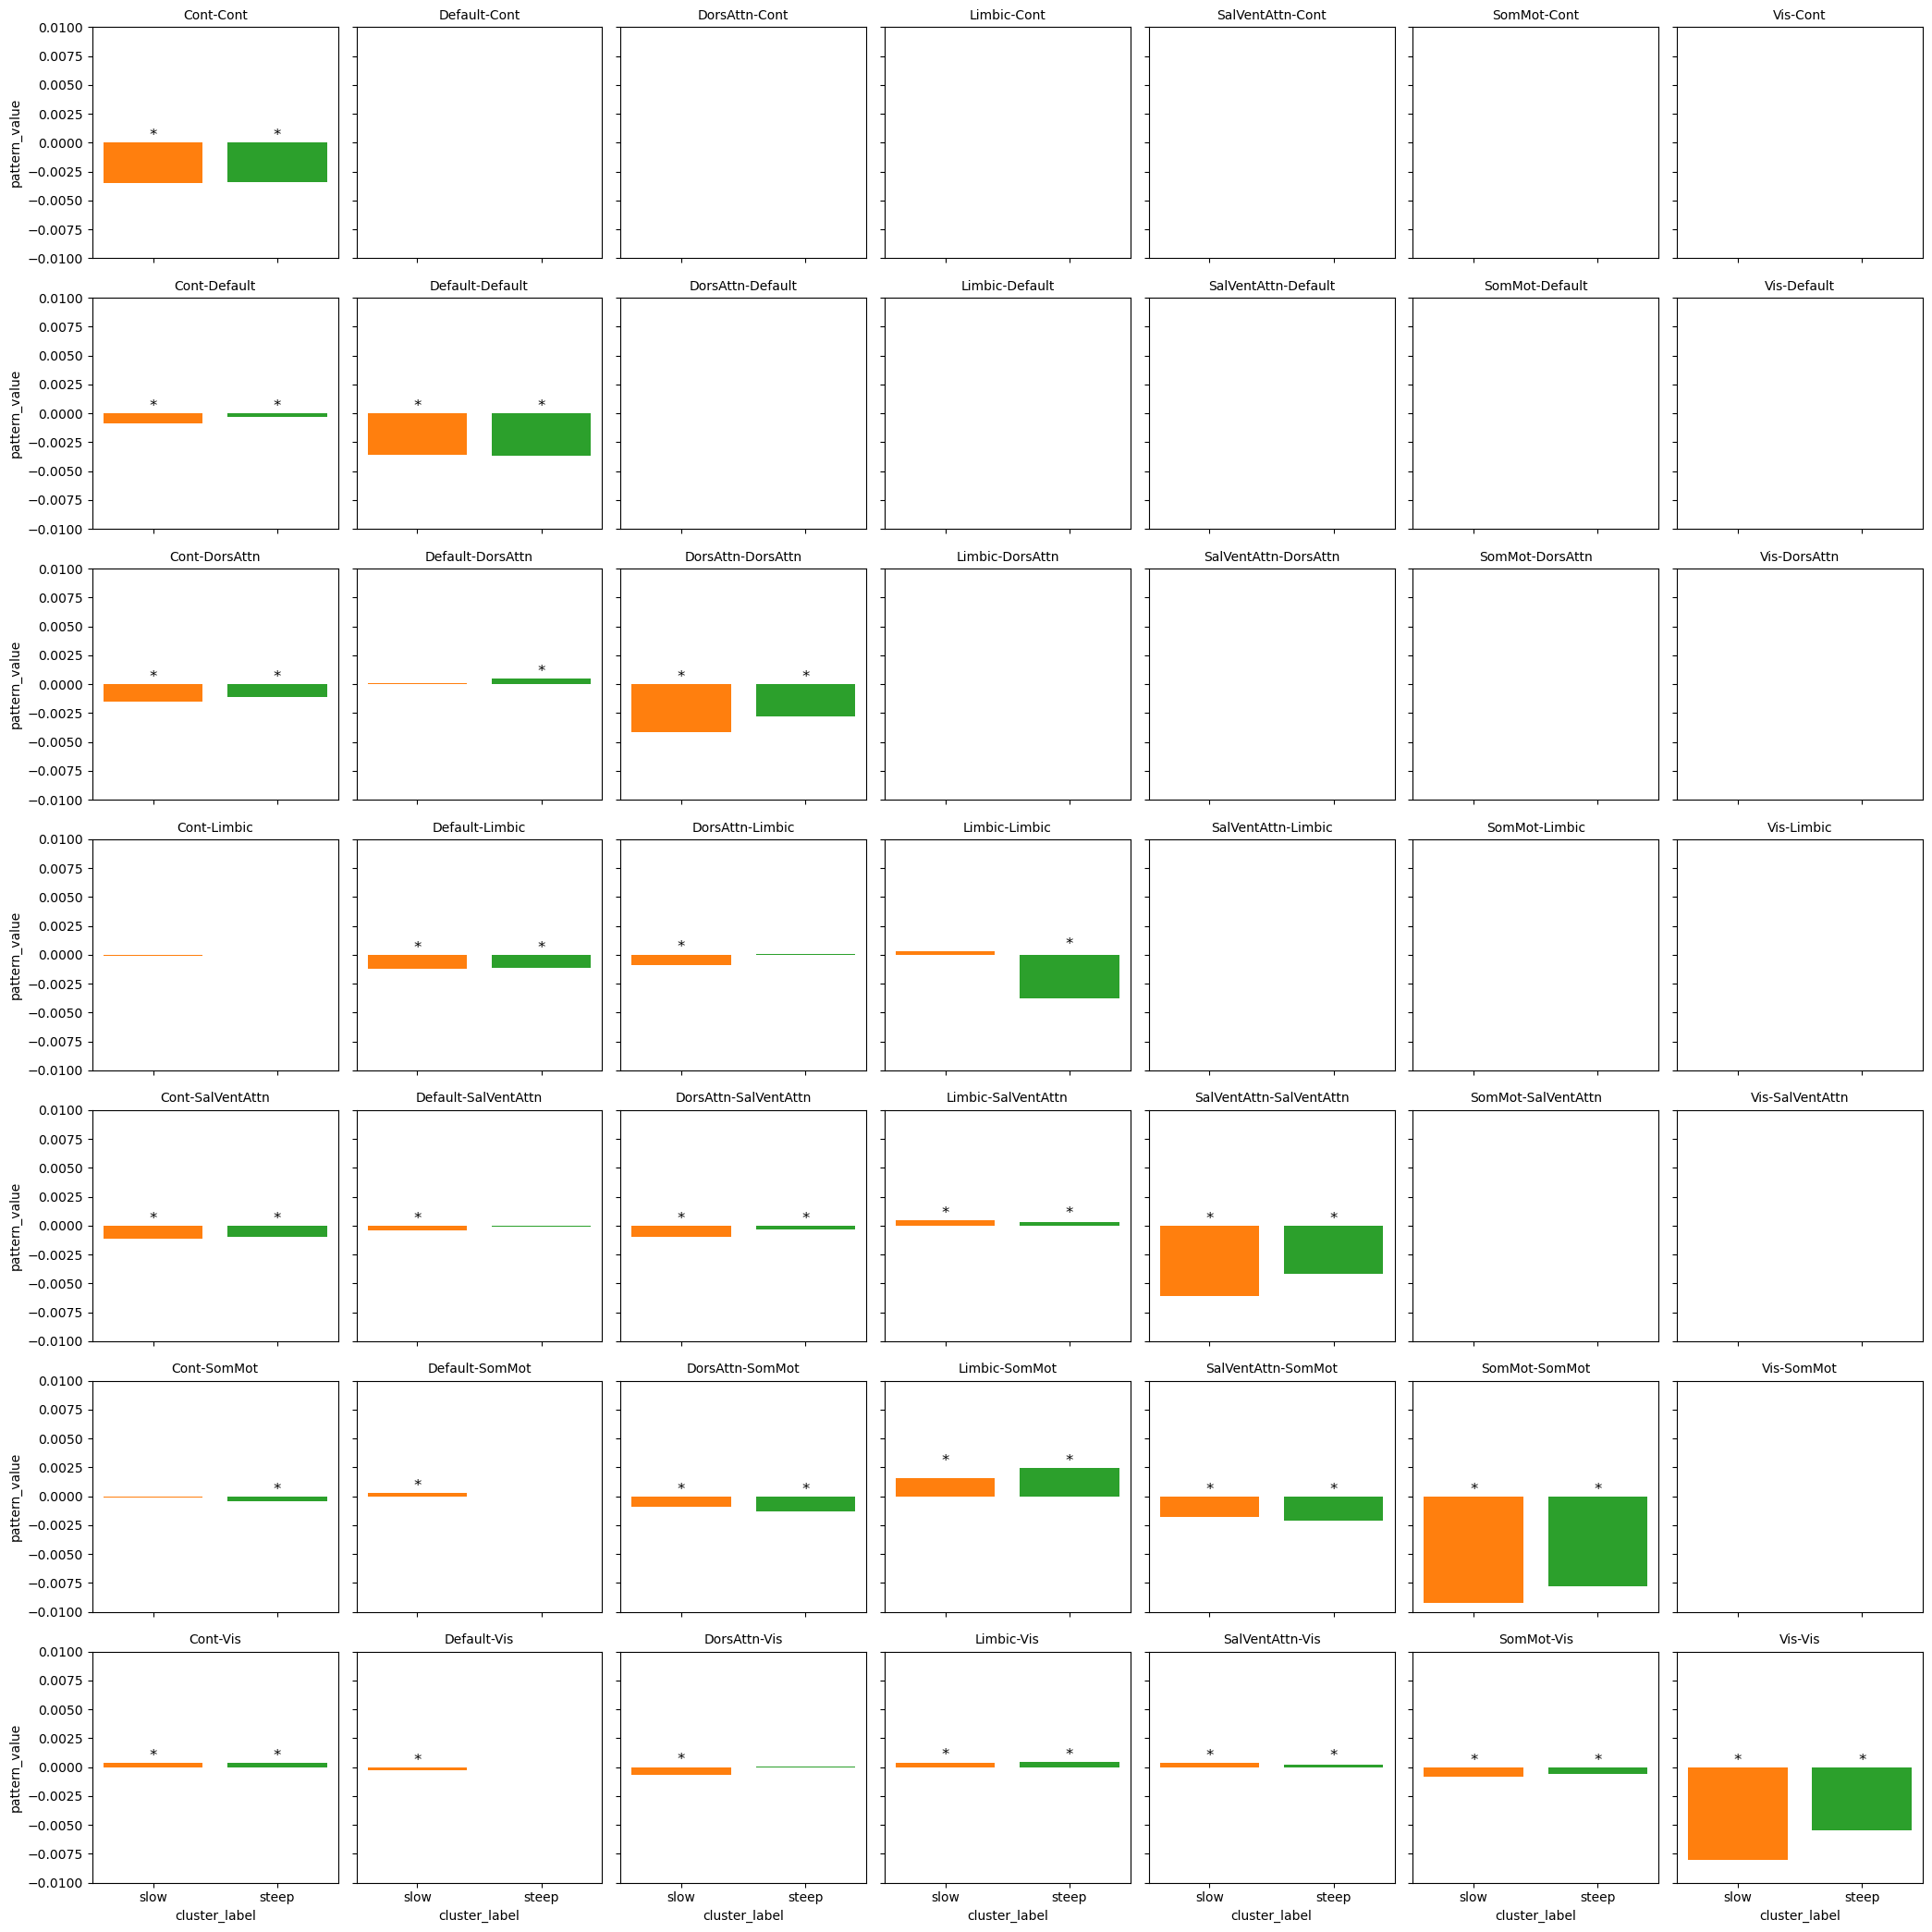

In [121]:
from itertools import product
from math import ceil

grid = sns.FacetGrid(
    df_scaled,
    col="node_a",
    row="node_b",
    hue="cluster_label",
    palette=("tab:orange", "tab:green"),
    margin_titles=False,
    sharex=True,
    sharey=True,
    despine=False,
    ylim=(-0.01, 0.01)
)
grid.map(plt.bar, "cluster_label", "pattern_value")
grid.set_titles(template="{col_name}-{row_name}")
grid.set(xticks=[1, 2])
grid.set_xticklabels(("slow", "steep"))
y = 0.002

tril_idx = idx = np.tril_indices_from(grid.axes)

comp_pairs = (
    (1, (1, 0)),
    (2, (2, 0)),
    #(3, (2, 1)),
)

for ax in grid.axes[tril_idx]:
    
    networks = tuple(ax.title.get_text().split("-"))
    gridmsk = (test_outcome.sorted_pair == tuple(networks))
   
    y = df_scaled[df_scaled.sorted_pair == networks].pattern_value.max()
    y = max(0, y)
    print(networks, y)
    #y = 0.002
    # TODO Sort test outcomes like df to get max value and debug this
    #y = df[df.sorted_pair.values == net_key].pattern_value.max()
    
    for x, (a, b) in comp_pairs:
        col_msk = (test_outcome.clusterlabel_a == a) & (test_outcome.clusterlabel_b == b)
        pval = test_outcome.loc[gridmsk & col_msk, "p adj"].values[0]

        if pval < 0.05:
            annotation = "*"
        elif pval < 0.01:
            annotation = "**"
        elif pval < 0.001:
            annotation = "***"
        else:
            annotation = ""

        ax.text(x, y, annotation, ha="center", va="bottom", fontsize=12, color="black")


In [16]:
decliners = sns.color_palette("tab10")[1:3]

In [17]:
intranet_msk = (df_scaled.node_a == df_scaled.node_b)
df_scaled[intranet_msk]

,node_a,node_b,pattern_value,cluster_label,fold,sorted_pair
0,Cont,Cont,-0.003396,1,0,"(Cont, Cont)"
8,Default,Default,-0.003548,1,0,"(Default, Default)"
16,DorsAttn,DorsAttn,-0.004061,1,0,"(DorsAttn, DorsAttn)"
24,Limbic,Limbic,0.000314,1,0,"(Limbic, Limbic)"
32,SalVentAttn,SalVentAttn,-0.005998,1,0,"(SalVentAttn, SalVentAttn)"
...,...,...,...,...,...,...
16,DorsAttn,DorsAttn,-0.002827,2,7,"(DorsAttn, DorsAttn)"
24,Limbic,Limbic,-0.003752,2,7,"(Limbic, Limbic)"
32,SalVentAttn,SalVentAttn,-0.004199,2,7,"(SalVentAttn, SalVentAttn)"
40,SomMot,SomMot,-0.007781,2,7,"(SomMot, SomMot)"


Text(0.5, 1.0, 'Aggregated Pattern differences')

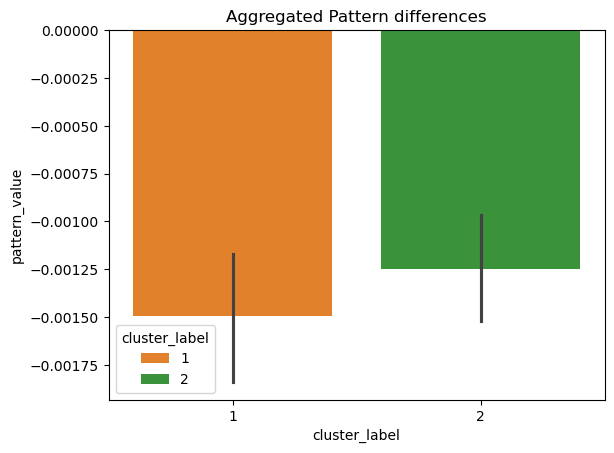

In [18]:
sns.barplot(df_scaled, x="cluster_label", y="pattern_value", hue="cluster_label", palette=decliners)
plt.title("Aggregated Pattern differences")

In [19]:
df_scaled

,node_a,node_b,pattern_value,cluster_label,fold,sorted_pair
0,Cont,Cont,-0.003396,1,0,"(Cont, Cont)"
1,Cont,Default,-0.000883,1,0,"(Cont, Default)"
2,Cont,DorsAttn,-0.001497,1,0,"(Cont, DorsAttn)"
3,Cont,Limbic,-0.000122,1,0,"(Cont, Limbic)"
4,Cont,SalVentAttn,-0.001098,1,0,"(Cont, SalVentAttn)"
...,...,...,...,...,...,...
33,SalVentAttn,SomMot,-0.002123,2,7,"(SalVentAttn, SomMot)"
34,SalVentAttn,Vis,0.000188,2,7,"(SalVentAttn, Vis)"
40,SomMot,SomMot,-0.007781,2,7,"(SomMot, SomMot)"
41,SomMot,Vis,-0.000550,2,7,"(SomMot, Vis)"


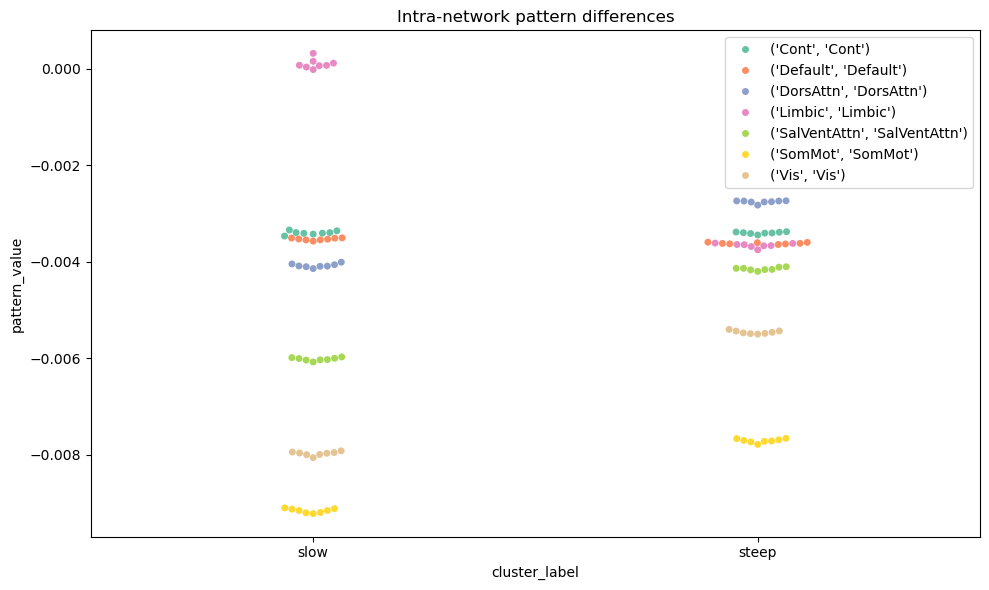

In [20]:
plt.subplots(figsize=(10, 6))
sns.swarmplot(df_scaled[intranet_msk], x="cluster_label", y="pattern_value", hue="sorted_pair", palette="Set2")
plt.title("Intra-network pattern differences")
plt.xticks(ticks=[0, 1], labels=["slow", "steep"])
plt.tight_layout()
plt.legend(loc="upper right")

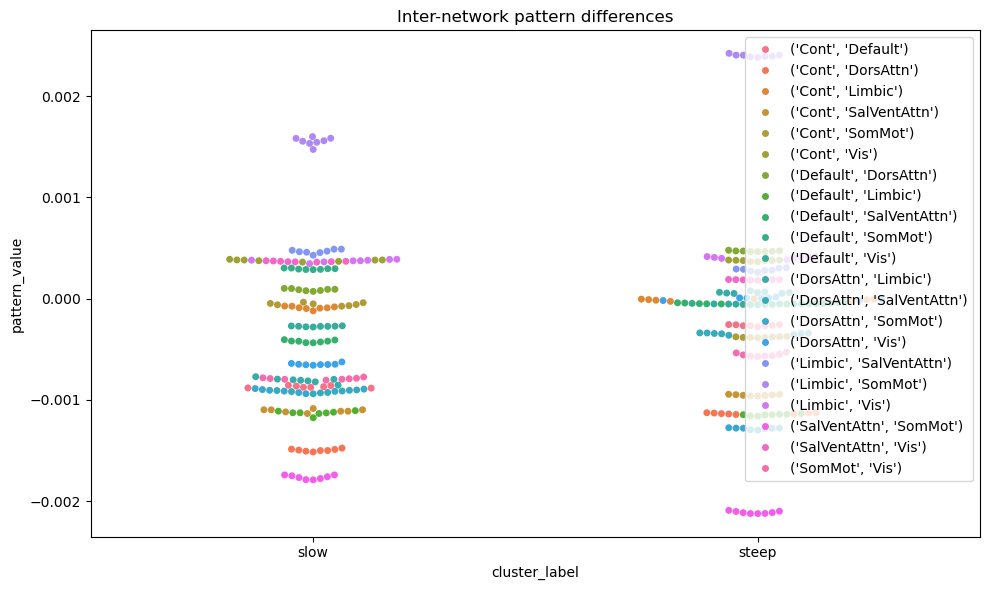

In [21]:
plt.subplots(figsize=(10, 6))
sns.swarmplot(df_scaled[~intranet_msk], x="cluster_label", y="pattern_value", hue="sorted_pair")
plt.title("Inter-network pattern differences")
plt.xticks(ticks=[0, 1], labels=["slow", "steep"])
plt.tight_layout()
plt.legend(loc="upper right")

Text(0.5, 1.0, 'Inter-network pattern differences')

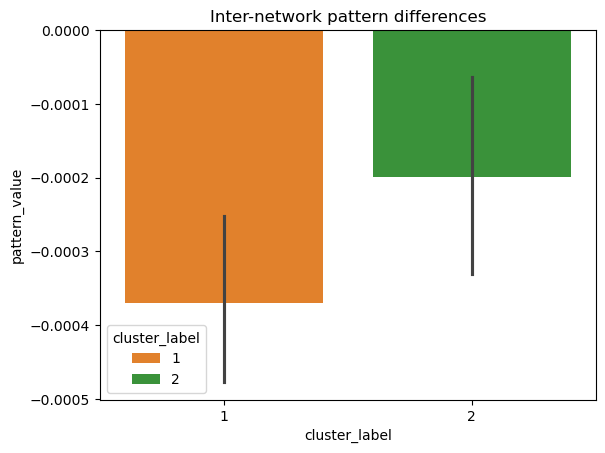

In [22]:
sns.barplot(df_scaled[~intranet_msk], x="cluster_label", y="pattern_value", hue="cluster_label", palette=decliners)
plt.title("Inter-network pattern differences")